In [33]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Import rasterio
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pathlib
from shapely.geometry import box

In [2]:
#uploading bundary file forclipping raster

folder = 'E:\GeospatialDataEssentials\GeospatialDataEssentials\exercise\data'
file_name = 'bd.gpkg'
vector = folder + '/' + file_name

boundary = gpd.read_file(vector)

In [5]:
boundary.head()

,Shape_Leng,Shape_Area,ADM0_EN,ADM0_PCODE,ADM0_REF,ADM0ALT1EN,ADM0ALT2EN,date,validOn,validTo,geometry
0,110.307505,12.396584,Bangladesh,BD,None,None,None,2015-01-01,2020-11-13,None,"MULTIPOLYGON (((92.32719 20.63543, 92.32749 20..."


In [4]:
# Define the raster file path
folder = 'E:\GeospatialDataEssentials\GeospatialDataEssentials\exercise\data2'
file_name = '2013.tif'
raster_file = folder + '/' + file_name
# Read the raster file
with rasterio.open(raster_file) as src:
# Read the raster data
    raster_data = src.read(1)
# Read additional information
    # profile = src.profile
    # bounds = src.bounds
    # resolution = src.res
    # mean_val = raster_data.mean()
    # min_val = raster_data.min()
    # max_val = raster_data.max()

In [5]:
# # Open the raster file and clip
with rasterio.open(raster_file) as src:
# Clip the raster using the bounding box
    out_image, out_transform = mask(src, boundary.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
})
# Print the profile of the clipped raster
print("Profile of the clipped raster:")
for key, value in out_meta.items():
    print(f"{key}: {value}")

# Step 7: Save the clipped raster
with rasterio.open('clipped_raster.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

Profile of the clipped raster:
driver: GTiff
dtype: float32
nodata: None
width: 519
height: 656
count: 1
crs: EPSG:4326
transform: | 0.01, 0.00, 88.03|
| 0.00,-0.01, 26.64|
| 0.00, 0.00, 1.00|


In [34]:
# Open the raster file and read the data
# Path to your clipped raster file
clipped_raster_file = 'clipped_raster.tif'
# Open the raster file and read the data
with rasterio.open(clipped_raster_file) as src:
    raster_data = src.read(1)
    transform = src.transform
    rows, cols = raster_data.shape
# Create lists to hold point geometries and cell values
polygons = []
values = []

for row in range(rows):
    for col in range(cols):
        value = raster_data[row, col]
        if value > 0:
            # Get the (x, y) coordinates for the cell corners
            # Use polygons instead of points: Instead of representing each cell as a point, 
            # you could represent it as a small polygon (square). This would create a continuous grid-like representation:
            
            x1, y1 = rasterio.transform.xy(transform, row, col)
            x2, y2 = rasterio.transform.xy(transform, row+1, col+1)
            # Create a polygon for the cell
            cell = box(x1, y1, x2, y2)
            polygons.append(cell)
            values.append(value)

,geometry,value
0,"POLYGON ((88.41668 26.63056, 88.41668 26.62157...",2.315345
1,"POLYGON ((88.40770 26.62157, 88.40770 26.61259...",1.283563
2,"POLYGON ((88.41668 26.62157, 88.41668 26.61259...",1.385426
3,"POLYGON ((88.42566 26.62157, 88.42566 26.61259...",1.793184
4,"POLYGON ((88.39872 26.61259, 88.39872 26.60361...",1.199635


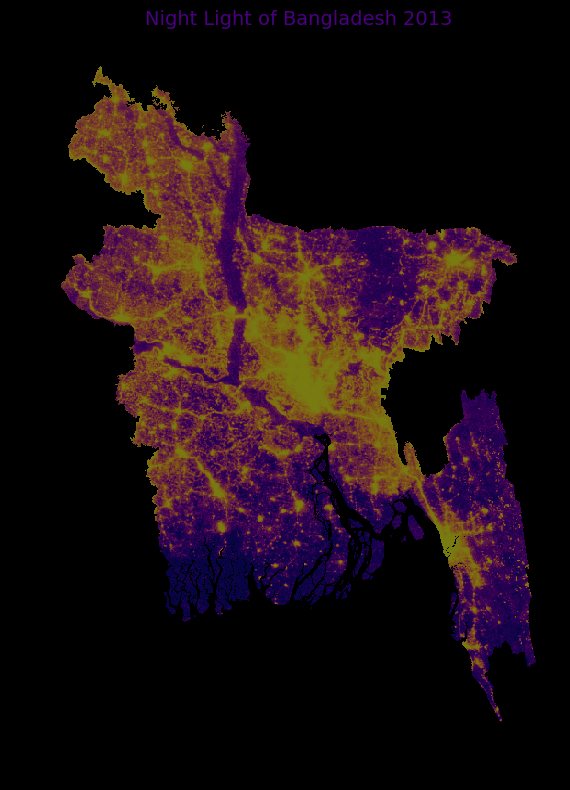

In [64]:
# Create a GeoDataFrame
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': polygons, 'value': values})
# Use the original CRS of the raster data
gdf.crs = src.crs

# Print the size of the GeoDataFrame
# print(len(gdf))
# Display the GeoDataFrame
display(gdf.head())

# Normalize the population values for better visualization
# norm = LogNorm(vmin=gdf['value'].min(), vmax=gdf['value'].max())

# Classifying the temperature into categories
# bins = [0, 10, 80]  # You can modify the bin ranges as per your data
# labels = [1,2]
gdf['density_quantile'] = pd.qcut(gdf['value'], q=40)
# gdf['temp'] = pd.cut(gdf['value'], bins=bins, labels=labels)

# Plot the GeoDataFrame
f, ax = plt.subplots(1, 1, figsize=(14,8))
gdf.plot(column='density_quantile', ax=ax, cmap='plasma', alpha=0.5, legend=False)  #legend false to add color bar, ndvi = RdYlGn,ndwi=RdBu
# cax = gdf.plot(column='temperature', ax=ax, cmap='hot_r', markersize=1, alpha=0.7, legend=False) #ndbi =RdBu
# Create a divider for the existing axes instance
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="3%", pad=0.3)
# # Add a colorbar with a vertical orientation
# sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
# sm._A = []  # This is needed to avoid an error
# cbar = plt.colorbar(sm, cax=cax)
# cbar.set_label('Temperature (°C)', rotation=270, labelpad=15)

f.patch.set_facecolor('black')
ax.set_facecolor('black')
# Add map title and axis labels in red color
ax.set_title('Night Light of Bangladesh 2013', fontsize=14,  color='indigo')
plt.tight_layout()
# saving the map
# NOTEBOOK_PATH = pathlib.Path().resolve()
# Map = NOTEBOOK_PATH / "../Map" 

# figure_path = os.path.join(Map, "2023_ndwi.png")
# plt.tight_layout()
# plt.savefig(figure_path, dpi=300) #define the size

In [8]:
gdf['value'].min()

0.020405386

In [9]:
gdf['value'].max()

70.699394

NameError: name 'length' is not defined

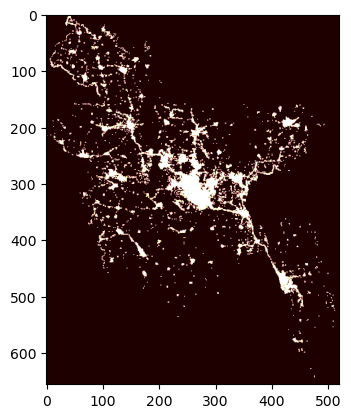

<Axes: >

In [32]:
# Import necessary libraries
import rasterio
import numpy as np
from rasterio.plot import show
# Define the output file path
clipped_raster_file = 'clipped_raster.tif'
# Open the raster file
with rasterio.open(clipped_raster_file) as src:
    raster_data = src.read(1)
    profile = src.profile
# Define reclassification rules
def reclassify(value):
    if value <0:
        return 1 # Low population density
    elif value < .5:
        return 2 # Medium population density
    else:
        return 3 # High population density
# Apply reclassification
reclassified = np.vectorize(reclassify)(raster_data)
# Visualize the reclassified raster
show(reclassified, cmap='pink')
# Visualize the histogram of the reclassified raster data